# Company Bankruptcy Prediction

In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay,PrecisionRecallDisplay,RocCurveDisplay,precision_score,\
recall_score,f1_score,roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from scipy.stats import randint
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
import shap
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cb
from catboost import CatBoostClassifier
import pickle
from itertools import combinations

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 120)
#pd.set_option('display.max_rows', None)
#pd.reset_option('display')
import warnings
warnings.filterwarnings('ignore')

## Getting familiar with the dataset

In [198]:
df=pd.read_csv('data.csv')

In [199]:
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,0.458143,7.250725e-04,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,2.559237e-02,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,0.461867,6.470647e-04,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [201]:
df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [202]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

## EDA

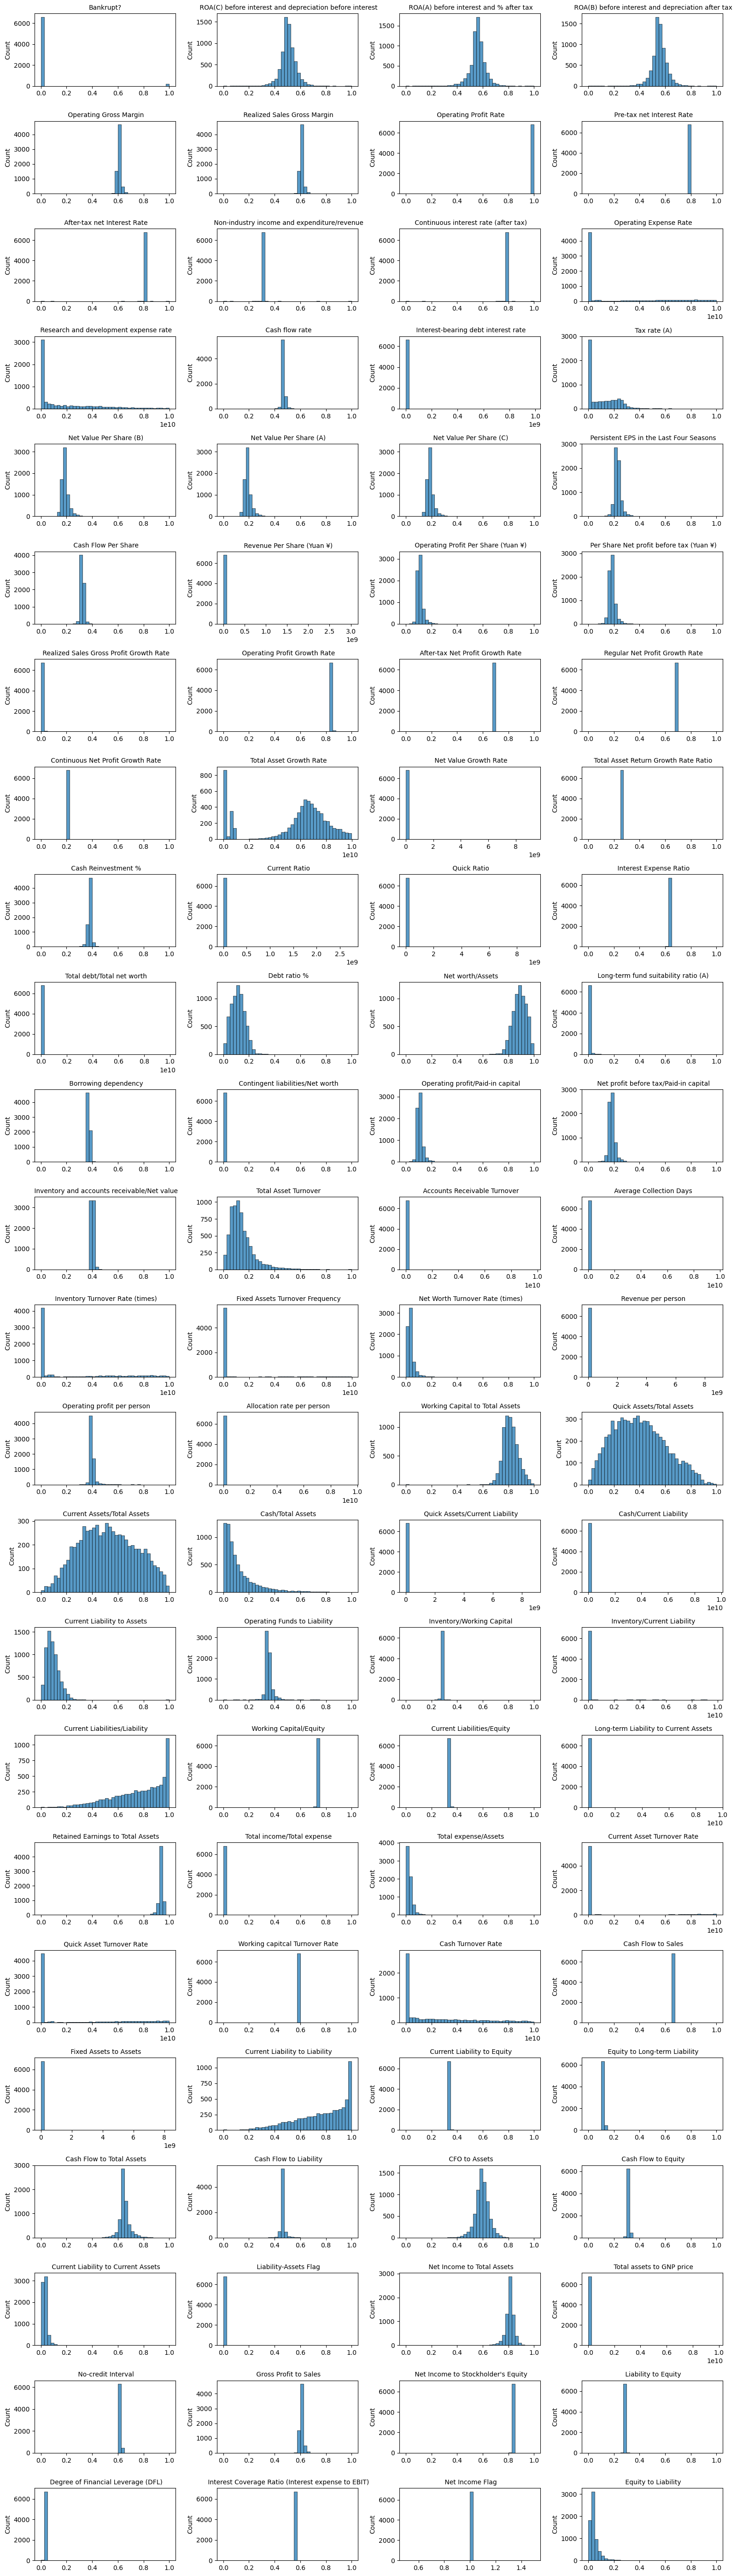

In [203]:
fig, axes = plt.subplots(nrows=24, ncols=4, figsize=(16, 56))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    ax = axes[i]  
    sns.histplot(data=df,x=col, bins=40, ax=ax)
    ax.set_title(col,fontsize=10)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

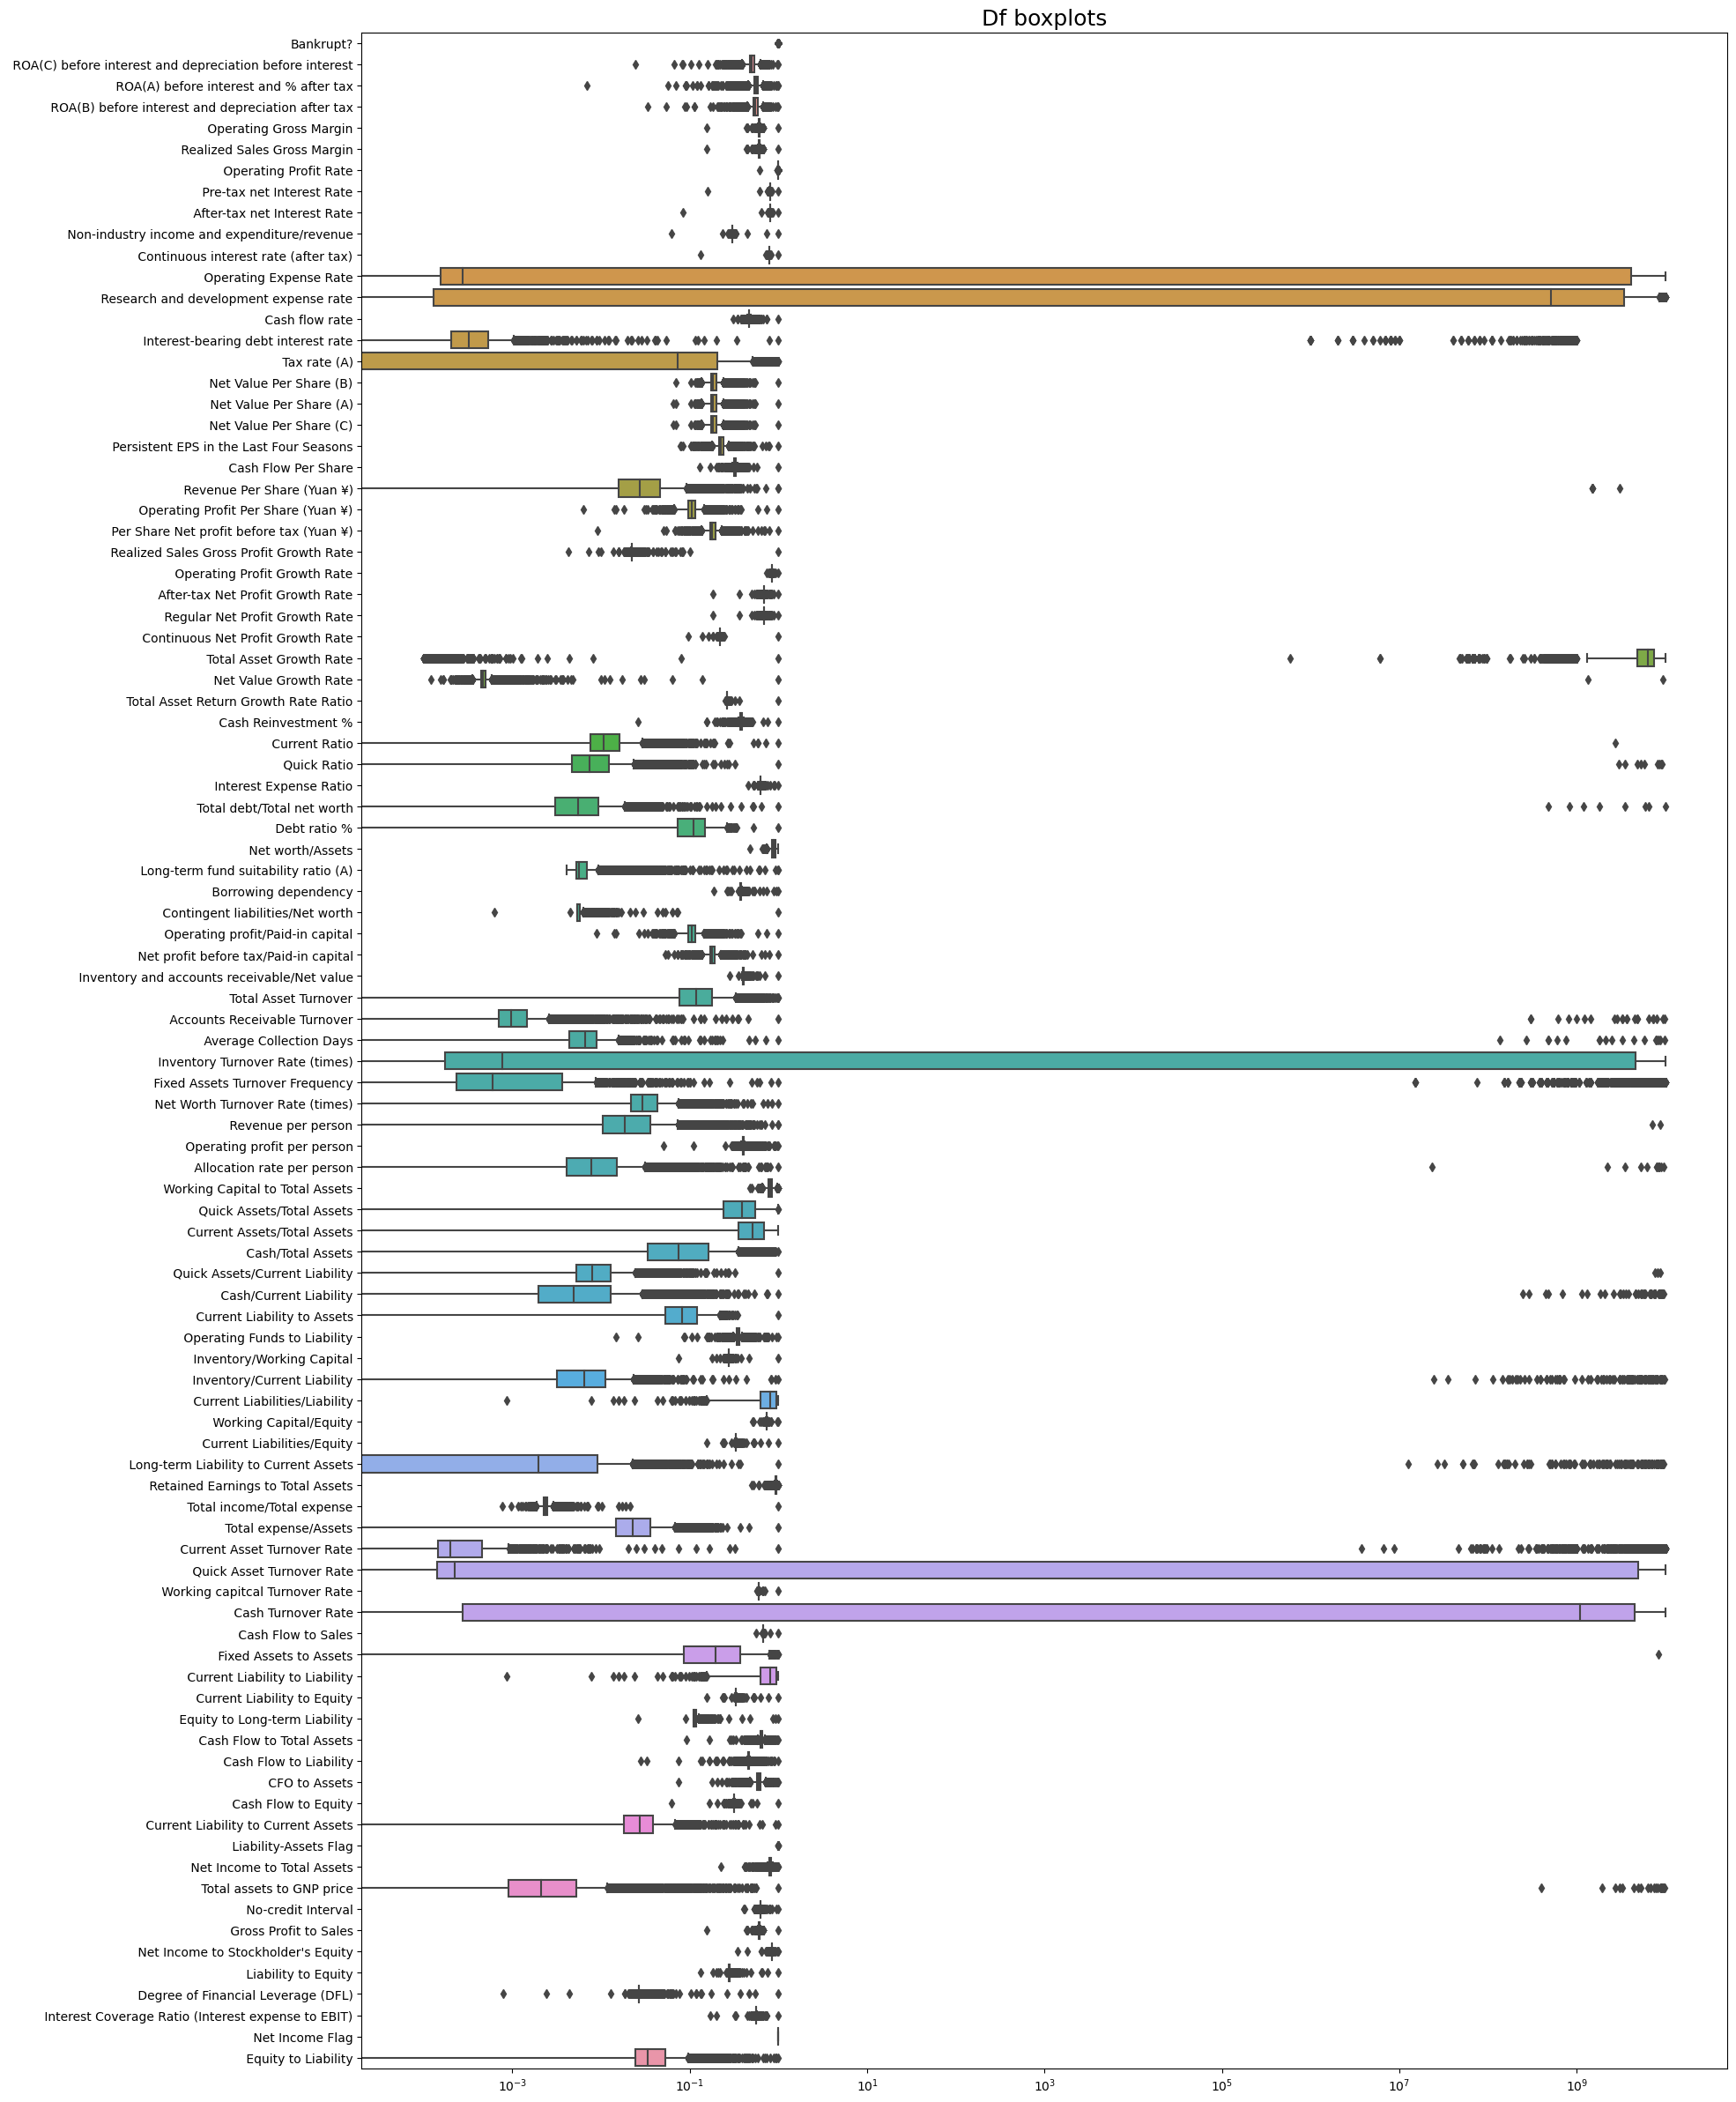

In [204]:
plt.figure(figsize = (20,30))
ax =sns.boxplot(data = df, orient="h")
ax.set_title('Df boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

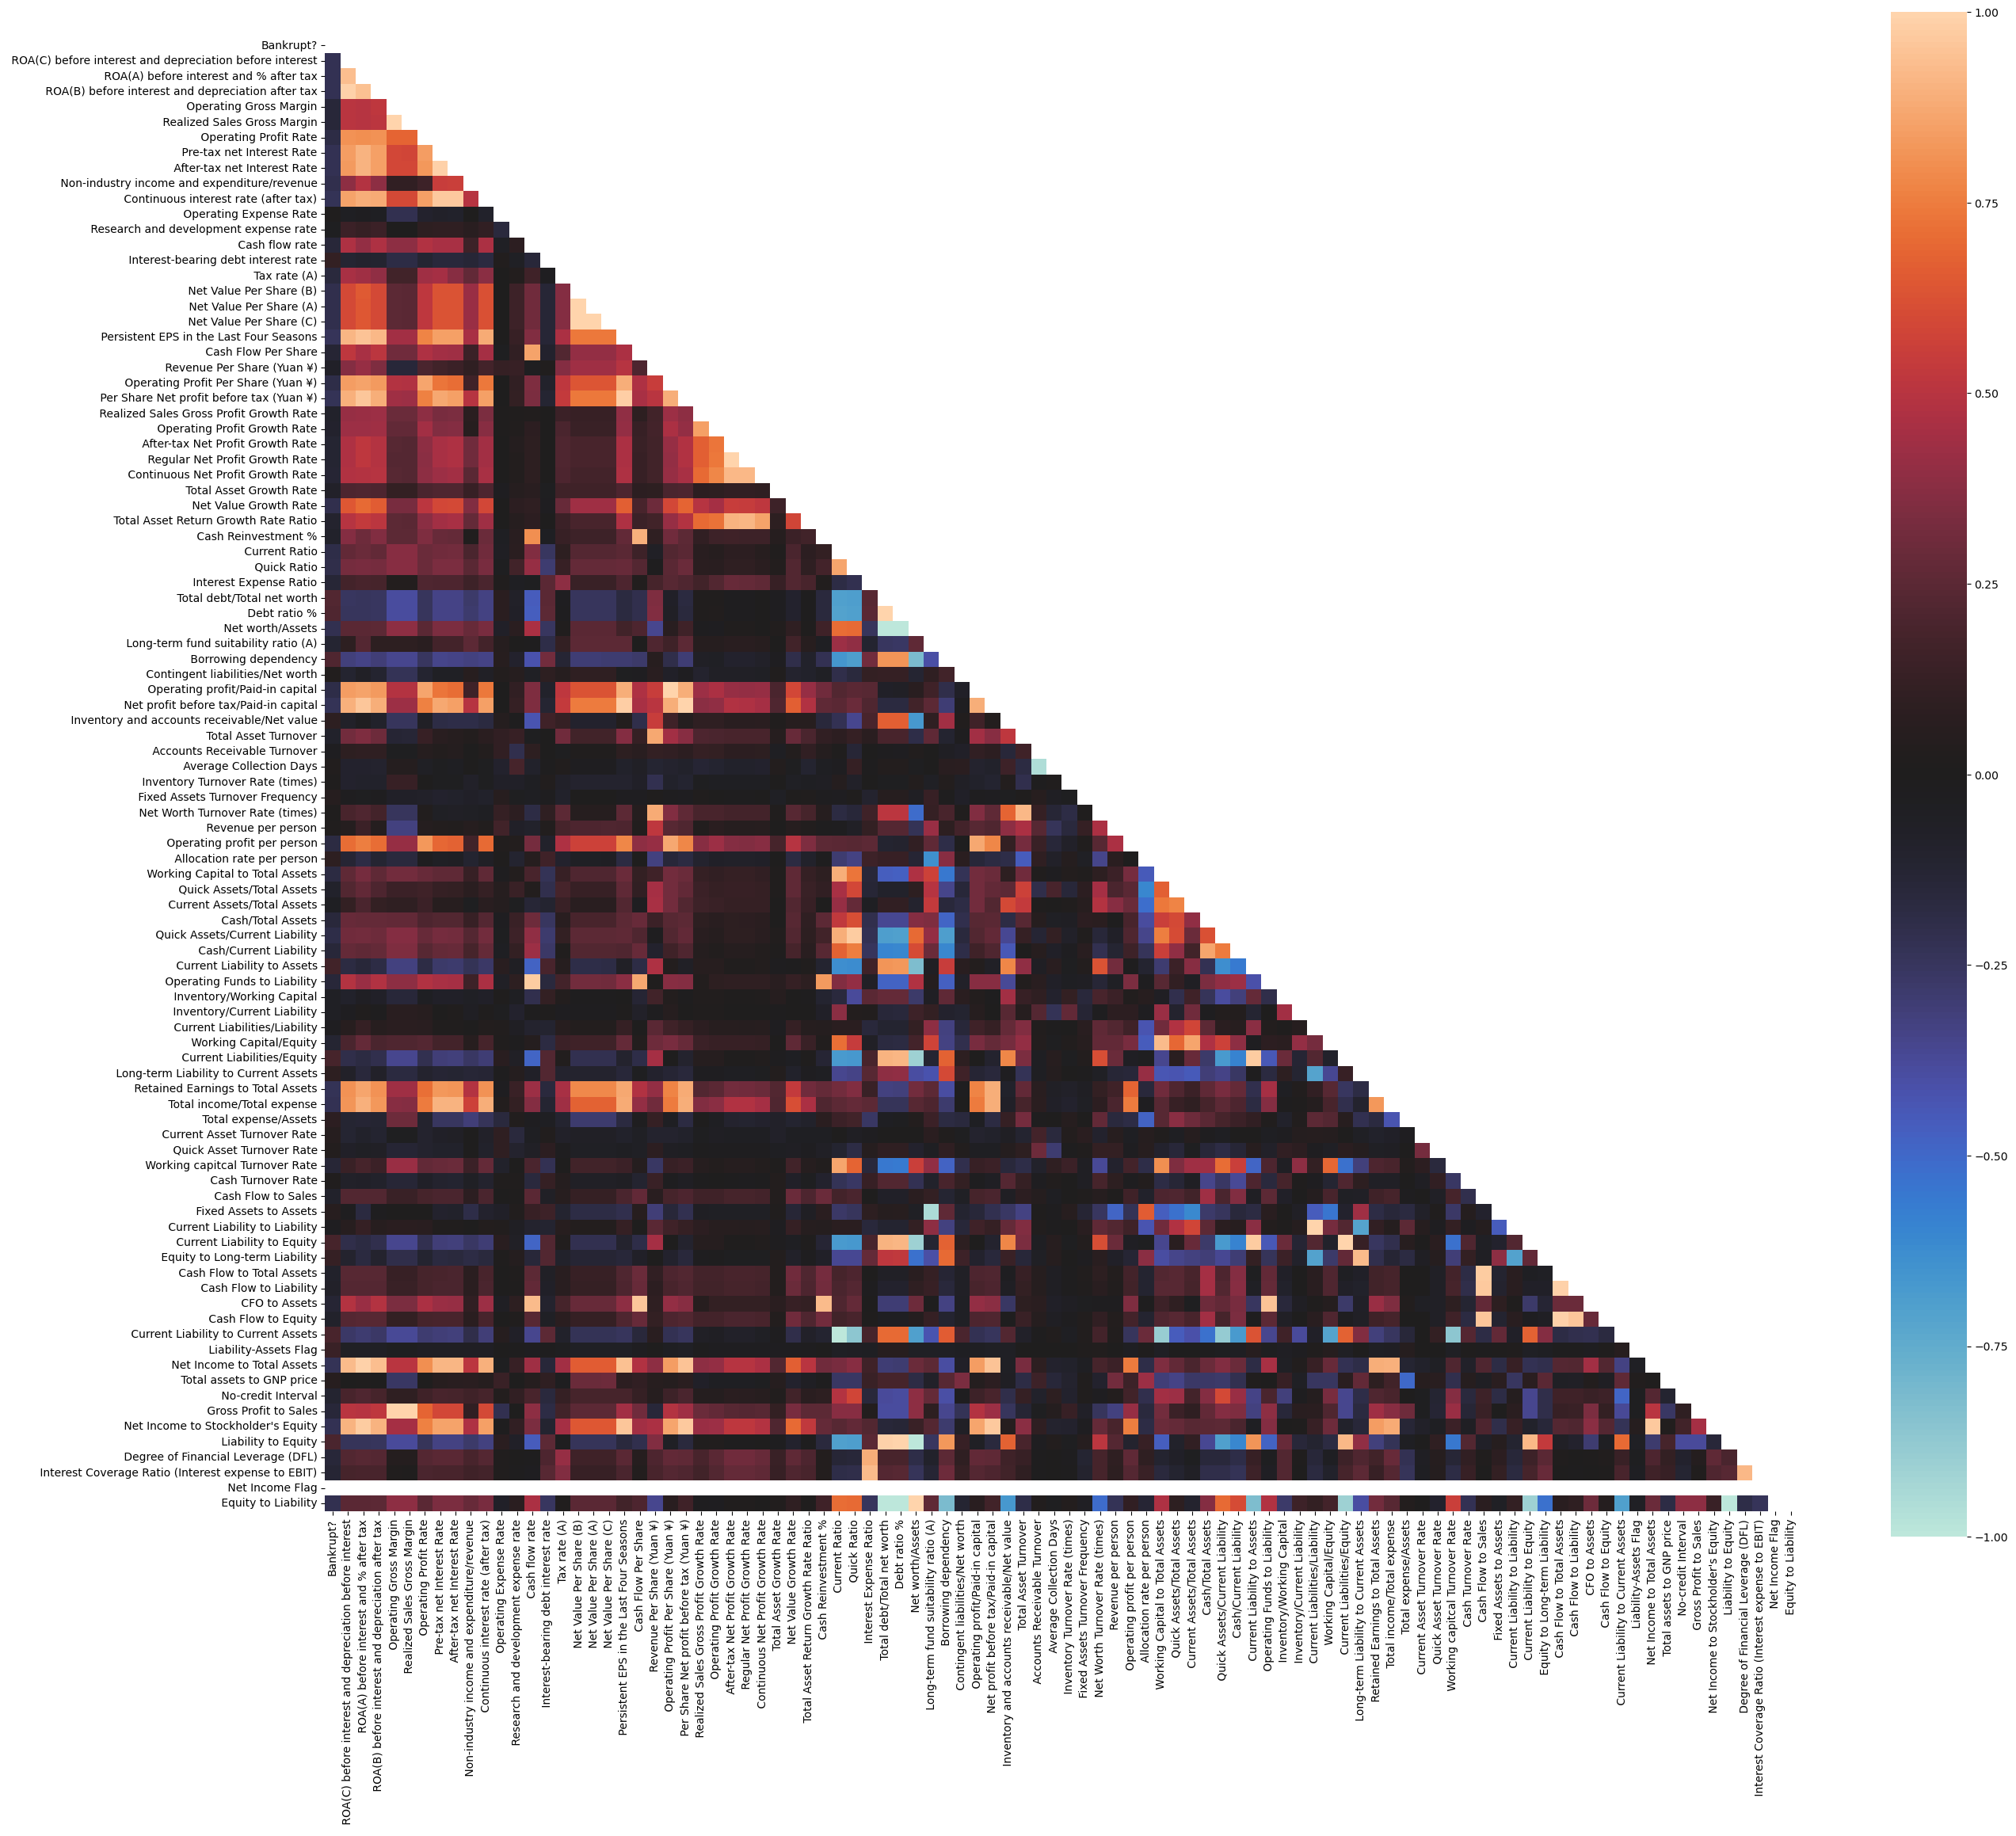

In [205]:
f, ax = plt.subplots(figsize=(30, 25))
corr = df.corr('spearman')
mask = np.triu(corr)
sns.heatmap(corr, vmin=-1, vmax=1, center=0, mask=mask, square=True)
plt.show()

In [206]:
top_10_gp = corr['Bankrupt?'].drop('Bankrupt?')
top_10_gp = top_10_gp.nlargest(10)
print("Top 10 Greatest Positive Correlations with Bankruptcy:")
print(top_10_gp)

Top 10 Greatest Positive Correlations with Bankruptcy:
 Total debt/Total net worth             0.219323
 Debt ratio %                           0.217237
 Borrowing dependency                   0.215094
 Liability to Equity                    0.200727
 Current Liability to Current Assets    0.189552
 Current Liabilities/Equity             0.182644
 Current Liability to Equity            0.182644
 Current Liability to Assets            0.168389
 Liability-Assets Flag                  0.139212
 Equity to Long-term Liability          0.117302
Name: Bankrupt?, dtype: float64


In [207]:
top_10_gn = corr['Bankrupt?'].nsmallest(10)
print("Top 10 Greatest Negative Correlations with Bankruptcy:")
print(top_10_gn)

Top 10 Greatest Negative Correlations with Bankruptcy:
 Persistent EPS in the Last Four Seasons                   -0.238209
 Net Income to Total Assets                                -0.234316
 Net profit before tax/Paid-in capital                     -0.233106
 Per Share Net profit before tax (Yuan ¥)                  -0.232442
 Retained Earnings to Total Assets                         -0.229533
 Continuous interest rate (after tax)                      -0.227621
 Total income/Total expense                                -0.224564
 ROA(B) before interest and depreciation after tax         -0.224163
 ROA(C) before interest and depreciation before interest   -0.223589
 ROA(A) before interest and % after tax                    -0.222410
Name: Bankrupt?, dtype: float64


In [208]:
top_corr = list(top_10_gn.index.union(top_10_gp.index))

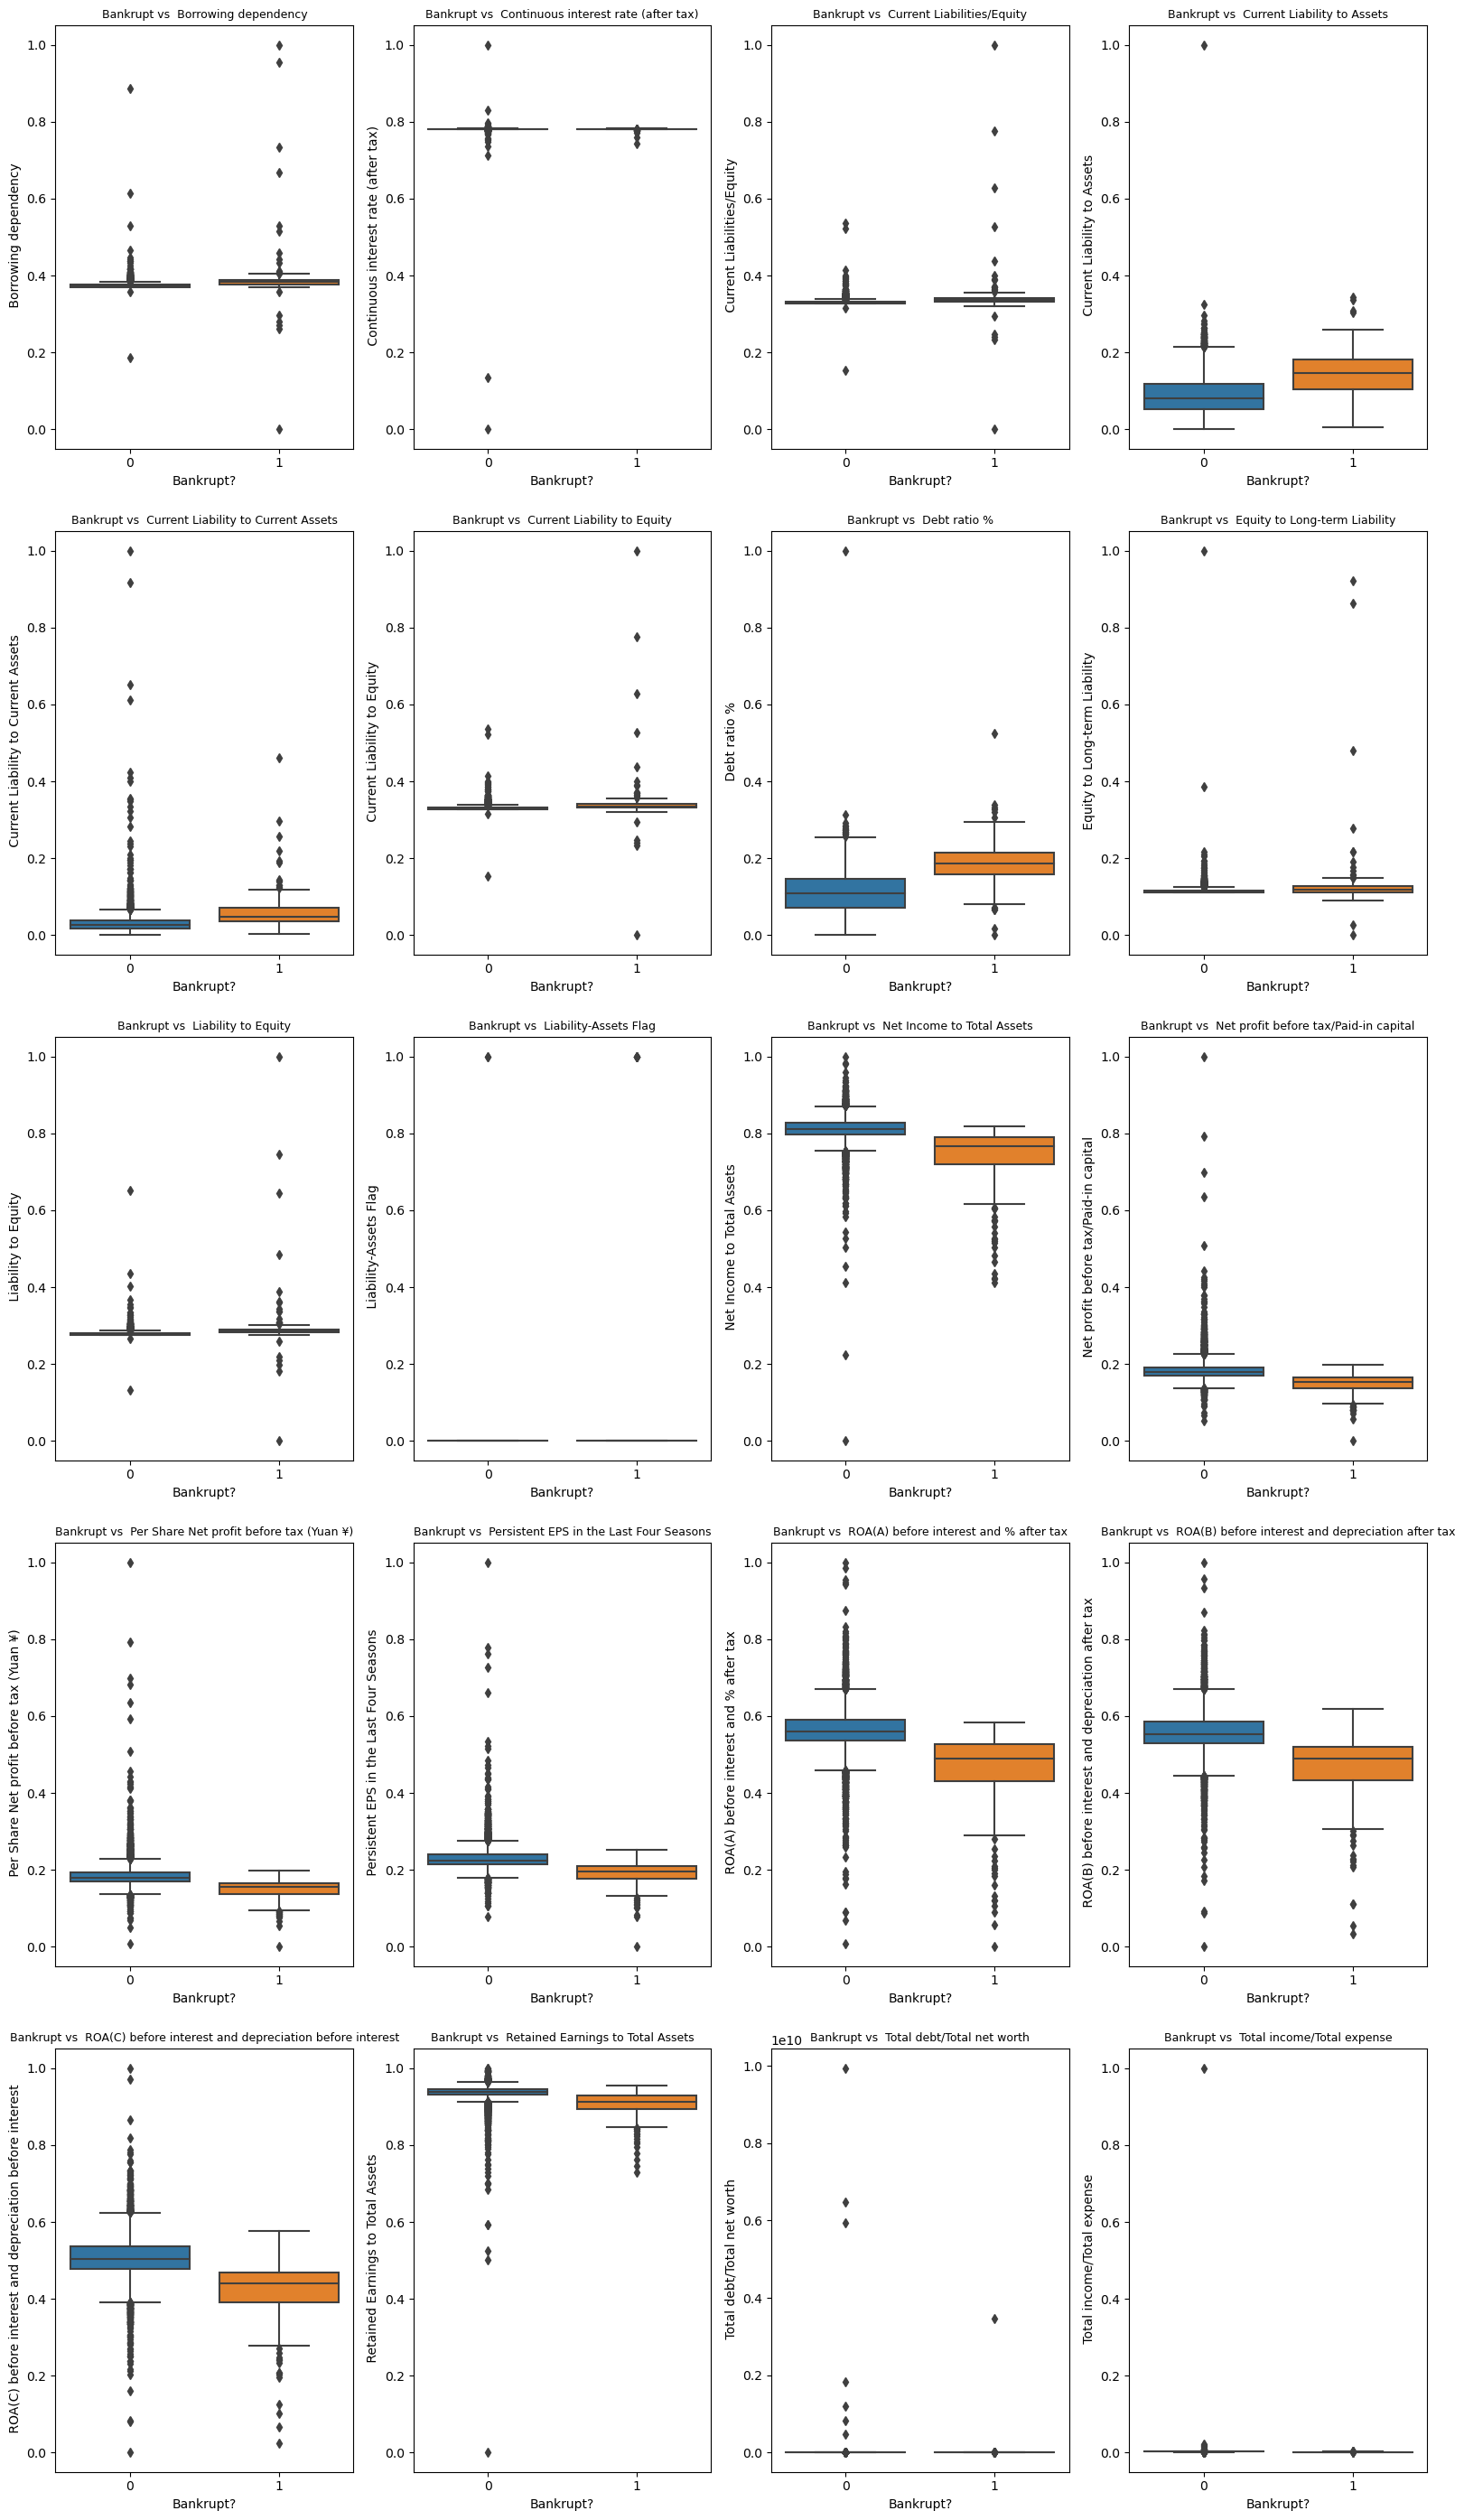

In [209]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16, 28))
axes = axes.ravel()

for i in range(len(top_corr)):
    sns.boxplot(x='Bankrupt?', y=top_corr[i], data=df, ax=axes[i])
    axes[i].set_title(f'Bankrupt vs {top_corr[i]}', fontsize=9)

plt.tight_layout()
plt.show()

## Feature Engineering

In [210]:
def split_scale(df,test_size):
    
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 ,random_state=42)
    print(f'X train shape:{X_train.shape}')
    print(f'X test shape:{X_test.shape}')
    print(f'y train shape:{y_train.shape}')
    print(f'y test shape:{y_test.shape}')
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train,columns=X.columns)
    X_test = pd.DataFrame(X_test,columns=X.columns)
    
    del df, X, y
    return X_train,X_test,y_train,y_test,scaler

In [211]:
# tuned hyperparameters (with all features) were used here

def feature_selection(X_train,X_test,y_train,y_test,kind,num_features,xgb_type=None):
    
    if kind=='kbest':
        kbest = SelectKBest(k=num_features,score_func=f_classif)
        kbest.fit(X_train,y_train)
        col_idxs = kbest.get_support(indices=True)
        selected_features = list(X_train.iloc[:,col_idxs].columns)
        selected_features = pd.DataFrame(selected_features,columns=['feature'])
        return selected_features
        
    elif kind=='rf':
        rf = SelectFromModel(estimator=RandomForestClassifier(random_state=42,
                                                              n_jobs=-1,
                                                              max_features=num_features,
                                                              n_estimators=100,
                                                              min_samples_split=6,
                                                              min_samples_leaf=8,
                                                              max_depth=7,
                                                              criterion='entropy',
                                                              class_weight={0: 1, 1: 20},
                                                              ccp_alpha=0,
                                                              bootstrap=True))
        rf.fit(X_train,y_train)
        col_idxs = rf.get_support(indices=True)
        selected_features = list(X_train.iloc[:,col_idxs].columns)
        selected_features = pd.DataFrame(selected_features,columns=['feature'])
        return selected_features[:num_features]
        
    elif kind=='cb':
        cb = CatBoostClassifier(subsample=0.9, 
                                score_function='L2',
                                scale_pos_weight=90,
                                sampling_frequency='PerTreeLevel',
                                rsm=0.9,
                                random_strength=60,
                                posterior_sampling=True,
                                penalties_coefficient=0.3,
                                n_estimators=500,
                                min_data_in_leaf=9,
                                loss_function='Logloss',
                                leaf_estimation_iterations=20,
                                l2_leaf_reg=6.0,
                                grow_policy='Depthwise',
                                depth=10)
        cb.fit(X_train,y_train,verbose=False)
        feat_imps = np.array(cb.feature_importances_)
        features = np.array(X_train.columns)
        dict={'feature':features,'importance':feat_imps}
        selected_features = pd.DataFrame(dict).sort_values(by='importance',ascending=False)
        return selected_features[:num_features]
        
    elif kind=='cb_shap':
        cb = CatBoostClassifier(subsample=0.9, 
                                score_function='L2',
                                scale_pos_weight=90,
                                sampling_frequency='PerTreeLevel',
                                rsm=0.9,
                                random_strength=60,
                                posterior_sampling=True,
                                penalties_coefficient=0.3,
                                n_estimators=500,
                                min_data_in_leaf=9,
                                loss_function='Logloss',
                                leaf_estimation_iterations=20,
                                l2_leaf_reg=6.0,
                                grow_policy='Depthwise',
                                depth=10)
        cb.fit(X_train,y_train,verbose=False)
        explainer = shap.Explainer(cb)
        shap_values = explainer(X_test)
        shap_importance = shap_values.abs.mean(0).values
        sorted_idxs = shap_importance.argsort()
        feature_names = shap_values.feature_names
        shap_df = pd.DataFrame(shap_values.values,columns=feature_names)
        vals = np.abs(shap_df.values).mean(0)
        shap_importance = pd.DataFrame(list(zip(feature_names,vals)),columns=['feature','importance'])
        shap_importance.sort_values(by=['importance'],ascending=False,inplace=True)
        return shap_importance[:num_features]
        
    elif kind=='xgb':
        xgb = XGBClassifier(random_state=42,
                         n_jobs=-1,
                         subsample=0.7,
                         scale_pos_weight=17,
                         reg_lambda=1.6,
                         reg_alpha=0.003,
                         n_estimators=300,
                         min_child_weight=11,
                         max_depth=9,
                         max_delta_step=0.1,
                         learning_rate=0.5,
                         gamma=2.1
                        )
        xgb.fit(X_train, y_train)
        
        feat_imps = xgb.get_booster().get_score(importance_type=xgb_type)
        keys = list(feat_imps.keys())
        values = list(feat_imps.values())
        feat_imps_df =pd.DataFrame(data=values,index=keys,columns=['importance']).sort_values(by='importance',ascending=False).reset_index()
        feat_imps_df.rename({'index':'feature'},axis=1,inplace=True)
        return feat_imps_df[:num_features]

In [212]:
X_train,X_test,y_train,y_test,scaler = split_scale(df,.2)

X train shape:(5455, 95)
X test shape:(1364, 95)
y train shape:(5455,)
y test shape:(1364,)


In [213]:
feature_selection(X_train,X_test,y_train,y_test,'kbest',15)

,feature
0,ROA(C) before interest and depreciation before interest
1,ROA(A) before interest and % after tax
2,ROA(B) before interest and depreciation after tax
3,Persistent EPS in the Last Four Seasons
4,Debt ratio %
5,Net worth/Assets
6,Borrowing dependency
7,Net profit before tax/Paid-in capital
8,Current Liability to Assets
9,Current Liabilities/Equity


In [214]:
feature_selection(X_train,X_test,y_train,y_test,'rf',15)

,feature
0,ROA(C) before interest and depreciation before interest
1,ROA(B) before interest and depreciation after tax
2,Pre-tax net Interest Rate
3,After-tax net Interest Rate
4,Non-industry income and expenditure/revenue
5,Continuous interest rate (after tax)
6,Net Value Per Share (B)
7,Net Value Per Share (A)
8,Persistent EPS in the Last Four Seasons
9,Per Share Net profit before tax (Yuan ¥)


In [215]:
feature_selection(X_train,X_test,y_train,y_test,'cb',15)

,feature,importance
37,Net worth/Assets,4.061180
89,Net Income to Stockholder's Equity,3.225290
39,Borrowing dependency,3.195953
34,Interest Expense Ratio,3.078334
85,Net Income to Total Assets,2.742506
1,ROA(A) before interest and % after tax,2.663674
36,Debt ratio %,2.647894
94,Equity to Liability,2.523680
67,Retained Earnings to Total Assets,2.413923
8,Non-industry income and expenditure/revenue,2.396716


In [216]:
feature_selection(X_train,X_test,y_train,y_test,'cb_shap',15)

,feature,importance
94,Equity to Liability,0.325214
37,Net worth/Assets,0.313785
8,Non-industry income and expenditure/revenue,0.303786
36,Debt ratio %,0.293638
85,Net Income to Total Assets,0.291545
39,Borrowing dependency,0.255956
34,Interest Expense Ratio,0.255754
7,After-tax net Interest Rate,0.177323
89,Net Income to Stockholder's Equity,0.172219
68,Total income/Total expense,0.166033


In [217]:
feature_selection(X_train,X_test,y_train,y_test,'xgb',15,'weight')

,feature,importance
0,Cash/Total Assets,60.0
1,Non-industry income and expenditure/revenue,54.0
2,Interest Coverage Ratio (Interest expense to EBIT),47.0
3,Total Asset Growth Rate,42.0
4,Current Liabilities/Liability,40.0
5,Quick Assets/Total Assets,40.0
6,Borrowing dependency,39.0
7,Operating Profit Growth Rate,38.0
8,Inventory/Working Capital,38.0
9,Operating profit per person,37.0


In [218]:
feature_selection(X_train,X_test,y_train,y_test,'xgb',15,'gain')

,feature,importance
0,Borrowing dependency,64.349121
1,Net worth/Assets,52.962730
2,Persistent EPS in the Last Four Seasons,47.243614
3,Net Income to Total Assets,39.585167
4,Non-industry income and expenditure/revenue,29.588051
5,Debt ratio %,28.084444
6,Continuous interest rate (after tax),26.204027
7,Total income/Total expense,23.961376
8,Retained Earnings to Total Assets,20.743971
9,Net Value Per Share (A),20.392937


In [219]:
feature_selection(X_train,X_test,y_train,y_test,'xgb',15,'cover')

,feature,importance
0,Borrowing dependency,597.483032
1,Net worth/Assets,516.369385
2,Debt ratio %,443.490784
3,Non-industry income and expenditure/revenue,413.228546
4,Net Income to Total Assets,387.427856
5,Revenue Per Share (Yuan ¥),385.479492
6,Retained Earnings to Total Assets,384.387787
7,Persistent EPS in the Last Four Seasons,380.969208
8,Per Share Net profit before tax (Yuan ¥),302.707092
9,Tax rate (A),301.634766


In [220]:
feature_selection(X_train,X_test,y_train,y_test,'xgb',15,'total_gain')

,feature,importance
0,Borrowing dependency,2509.615723
1,Non-industry income and expenditure/revenue,1597.754761
2,Persistent EPS in the Last Four Seasons,1417.308472
3,Net Income to Total Assets,1147.969849
4,Debt ratio %,702.111084
5,Net worth/Assets,688.515503
6,Retained Earnings to Total Assets,601.575134
7,Total income/Total expense,455.266144
8,Net Value Per Share (B),349.987762
9,Continuous interest rate (after tax),340.652344


In [221]:
feature_selection(X_train,X_test,y_train,y_test,'xgb',15,'total_cover')

,feature,importance
0,Borrowing dependency,23301.837891
1,Non-industry income and expenditure/revenue,22314.341797
2,Cash/Total Assets,13758.825195
3,Persistent EPS in the Last Four Seasons,11429.076172
4,Net Income to Total Assets,11235.408203
5,Retained Earnings to Total Assets,11147.246094
6,Debt ratio %,11087.269531
7,Inventory/Working Capital,9132.370117
8,Interest Coverage Ratio (Interest expense to EBIT),9009.910156
9,Net Value Per Share (B),8433.891602


In [222]:
final_features = [' Equity to Liability',' Net worth/Assets',' Non-industry income and expenditure/revenue',' Debt ratio %',\
                  ' Net Income to Total Assets',' Borrowing dependency',' Interest Expense Ratio',' After-tax net Interest Rate',\
                  ' Total income/Total expense',' Per Share Net profit before tax (Yuan ¥)',\
                  ' Current Liability to Equity',' Liability to Equity',' ROA(B) before interest and depreciation after tax',\
                  ' Retained Earnings to Total Assets',' ROA(A) before interest and % after tax',' Current Liability to Assets',\
                  ' Working Capital to Total Assets',' Total expense/Assets',' Tax rate (A)',' Current Liability to Current Assets',\
                  ' Persistent EPS in the Last Four Seasons',' Net profit before tax/Paid-in capital',\
                  ' ROA(C) before interest and depreciation before interest',' Pre-tax net Interest Rate',' Continuous interest rate (after tax)',\
                  ' Net Value Per Share (B)',' Net Value Per Share (A)'
]

X_train = X_train.loc[:,final_features]
X_test = X_test.loc[:,final_features]

## Modeling

In [223]:
models = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

In [224]:
def save_output(y_test,y_hat,model):
    precision = np.round(precision_score(y_test,y_hat,average='macro'),3)
    recall = np.round(recall_score(y_test,y_hat,average='macro'),3)
    f1 = np.round(f1_score(y_test,y_hat,average='macro'),3)
    roc_auc = np.round(roc_auc_score(y_test,y_hat,average='macro'),3)
    
    models.append(model)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

In [225]:
def reports(y_test, y_hat):
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_hat))

    ConfusionMatrixDisplay.from_predictions(y_test,y_hat)
    PrecisionRecallDisplay.from_predictions(y_test,y_hat)
    RocCurveDisplay.from_predictions(y_test,y_hat)

In [226]:
def ensemble(model1, model2, weight1, weight2, threshold, X_test, y_test):
    prob_model1 = model1.predict_proba(X_test)
    prob_model2 = model2.predict_proba(X_test)
    y_hat = prob_model1*weight1+prob_model2*weight2
    y_hat = np.where(y_hat>=threshold,1,0)
    return reports(y_test,y_hat)

### Logistic Regression

In [227]:
%%time
par_log = {
    'penalty': ['l2'],
    'solver' : ['lbfgs','liblinear'],
    'C': np.logspace(-4, 3, 8),
    'class_weight':[{0:1,1:1},{0:1,1:3},{0:1,1:5},{0:1,1:8},{0:1,1:10},{0:1,1:20},{0:1,1:30},{0:1,1:50},{0:1,1:75},{0:1,1:100},'balanced'] 
}

logistic = LogisticRegression(max_iter=10000, random_state=42)
search = RandomizedSearchCV(logistic, par_log, n_jobs=-1, scoring='f1_macro',random_state=42)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.681):
{'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': {0: 1, 1: 10}, 'C': 0.001}
CPU times: total: 406 ms
Wall time: 9.1 s



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1313
           1       0.34      0.55      0.42        51

    accuracy                           0.94      1364
   macro avg       0.66      0.75      0.69      1364
weighted avg       0.96      0.94      0.95      1364



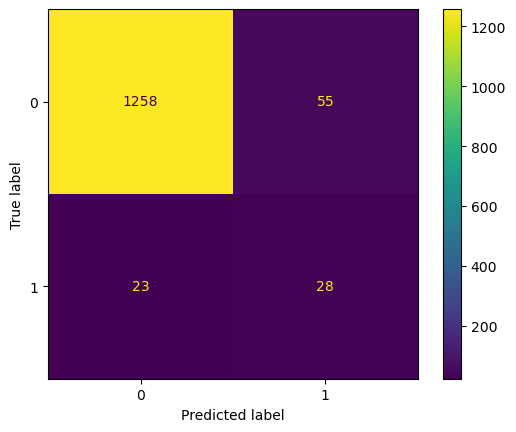

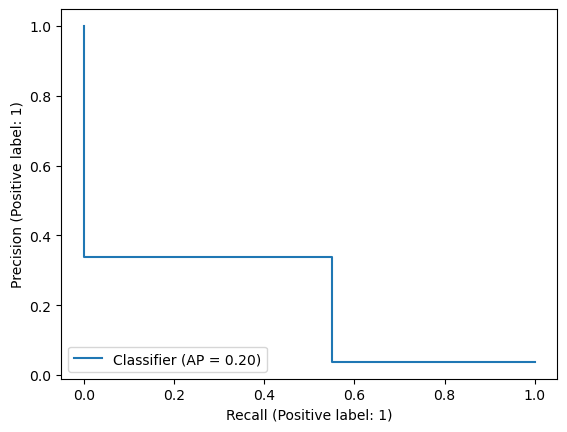

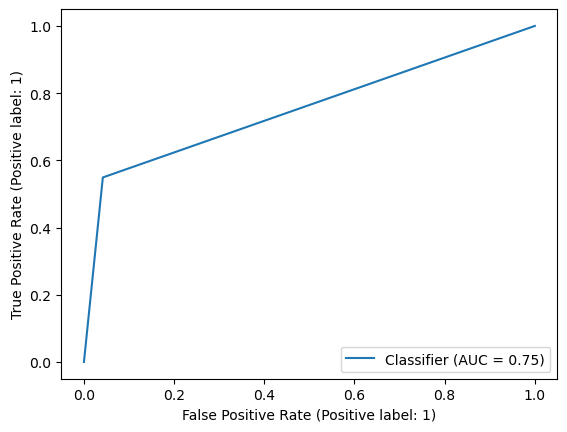

In [228]:
logistic_best = LogisticRegression(**search.best_params_,max_iter=10000, random_state=42)
logistic_best.fit(X_train, y_train)
y_hat = logistic_best.predict(X_test)

save_output(y_test,y_hat,'logistic')
reports(y_test, y_hat)

### Logistic Regression with SMOTE

In [229]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

In [230]:
%%time
par_log = {
    'penalty': ['l2'],
    'solver' : ['lbfgs','liblinear'],
    'C': np.logspace(-4, 3, 8)
}

logistic = LogisticRegression(max_iter=10000, random_state=42)
search2 = RandomizedSearchCV(logistic, par_log, n_jobs=-1, scoring='f1_macro',random_state=42)
search2.fit(X_train_SMOTE, y_train_SMOTE)

print("Best parameter (CV score=%0.3f):" % search2.best_score_)
print(search2.best_params_)

Best parameter (CV score=0.888):
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1000.0}
CPU times: total: 3.69 s
Wall time: 6.03 s



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1313
           1       0.19      0.82      0.31        51

    accuracy                           0.86      1364
   macro avg       0.59      0.84      0.62      1364
weighted avg       0.96      0.86      0.90      1364



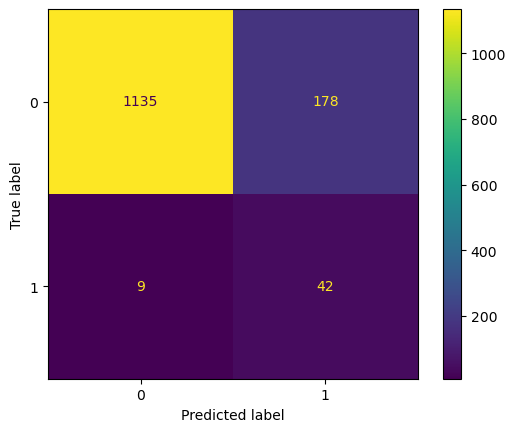

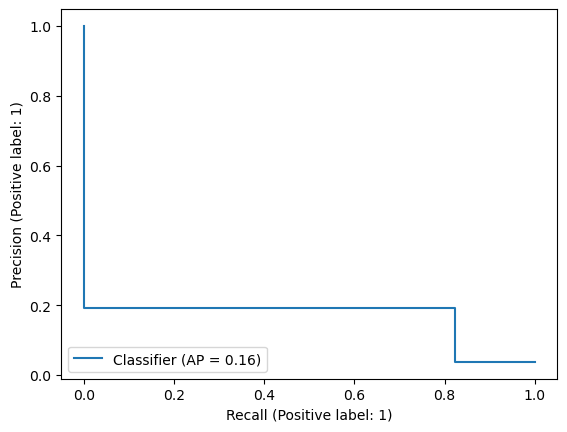

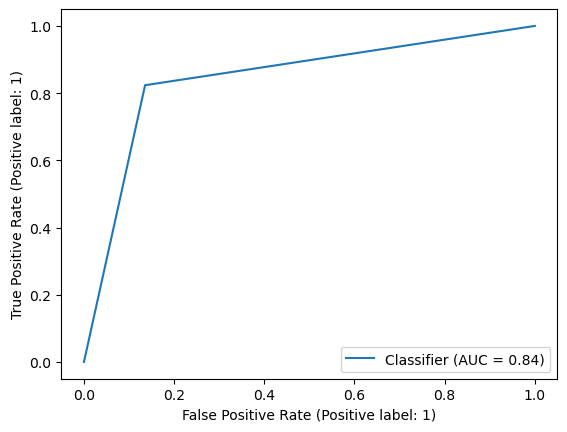

In [231]:
logistic_best_smote = LogisticRegression(**search2.best_params_,max_iter=10000, random_state=42)
logistic_best_smote.fit(X_train_SMOTE, y_train_SMOTE)
y_hat = logistic_best_smote.predict(X_test)

save_output(y_test,y_hat,'logistic-smote')
reports(y_test, y_hat)

### Random Forest Classifier

In [232]:
%%time
par = {
    'bootstrap': [True,False],
    'n_estimators':[100,200,300,400,500],
    'ccp_alpha':[0,.001,.01,.1],
    'criterion':['gini','entropy'],
    'min_samples_split':[4,6,7,8],
    'min_samples_leaf':[4,5,6,7,8],
    'max_depth':[6,7,8],
    'class_weight':[{0:1,1:60},{0:1,1:30},{0:1,1:20},{0:1,1:40},{0:1,1:50},{0:1,1:70},{0:1,1:80},'Balanced']
}

rf = RandomForestClassifier(random_state=42)
search3 = RandomizedSearchCV(rf, par, n_jobs=-1, scoring='f1_macro',random_state=42)
search3.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search3.best_score_)
print(search3.best_params_)

Best parameter (CV score=0.697):
{'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_depth': 8, 'criterion': 'gini', 'class_weight': {0: 1, 1: 30}, 'ccp_alpha': 0, 'bootstrap': True}
CPU times: total: 1.62 s
Wall time: 57.9 s



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1313
           1       0.37      0.65      0.47        51

    accuracy                           0.95      1364
   macro avg       0.68      0.80      0.72      1364
weighted avg       0.96      0.95      0.95      1364



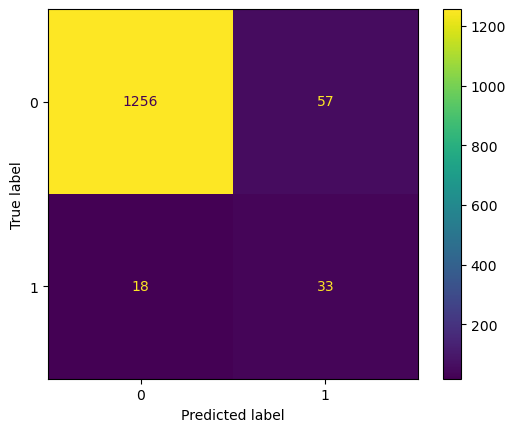

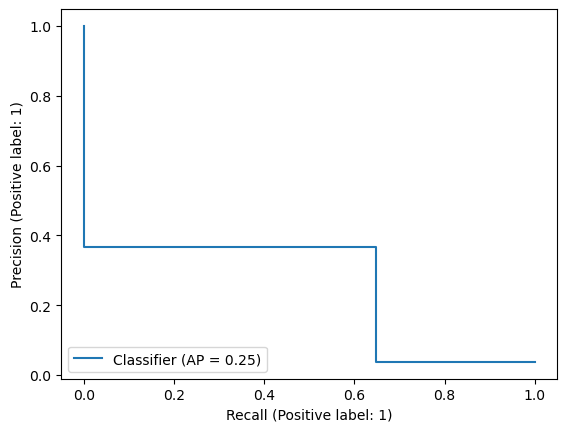

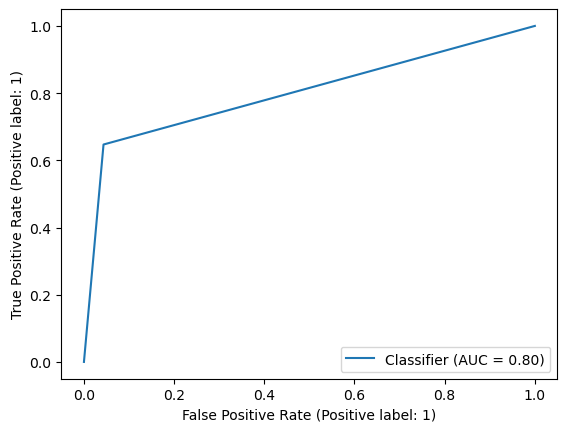

In [233]:
rf_best = RandomForestClassifier(**search3.best_params_, random_state=42)
rf_best.fit(X_train, y_train)
y_hat = rf_best.predict(X_test)

save_output(y_test,y_hat,'RF')
reports(y_test, y_hat)

### XGB Classifier

In [234]:
%%time 
par = {
    'min_child_weight':[10,12,15,20],
    'gamma':[1.8,1.9,2.1,2.2],
    'subsample':[.7,.8,.9,1],
    'max_depth':range(5,10,1),
    'learning_rate':[.4,.5,.6],
    'scale_pos_weight':np.arange(10,30,1),
    'reg_lambda':[1.4,1.5,1.6,1.7,1.8,1.9,2],
    'max_delta_step':[.05,.1,.15],
    'min_child_weight':[8,9,10,11,12],
    'n_estimators':np.arange(100,600,100),
    'reg_alpha':[0,.001,.003,.01]
}

xgb = XGBClassifier(random_state=42,n_jobs=-1)
search4 = RandomizedSearchCV(xgb, par, n_jobs=-1, scoring='f1_macro',random_state=42)
search4.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search4.best_score_)
print(search4.best_params_)

Best parameter (CV score=0.703):
{'subsample': 0.9, 'scale_pos_weight': 23, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 100, 'min_child_weight': 12, 'max_depth': 7, 'max_delta_step': 0.15, 'learning_rate': 0.6, 'gamma': 2.2}
CPU times: total: 1.67 s
Wall time: 9.79 s



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1313
           1       0.40      0.65      0.50        51

    accuracy                           0.95      1364
   macro avg       0.69      0.80      0.74      1364
weighted avg       0.96      0.95      0.96      1364



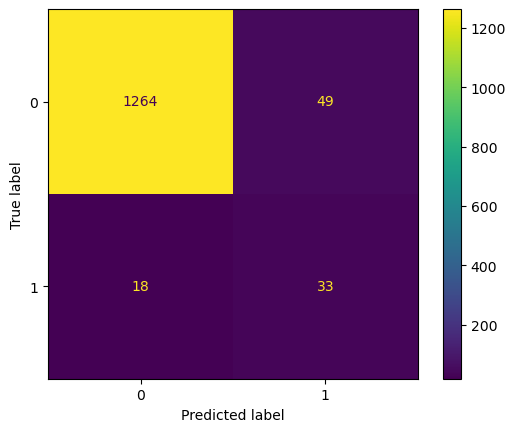

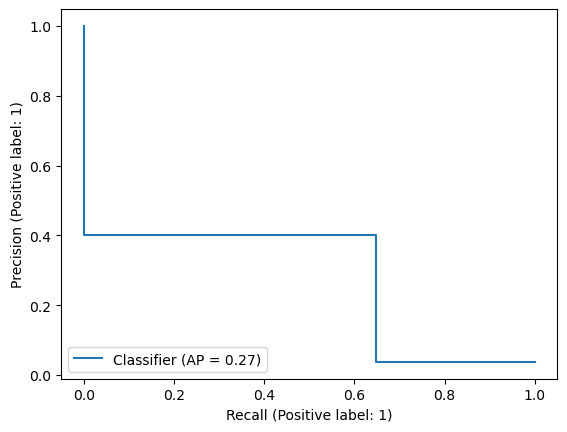

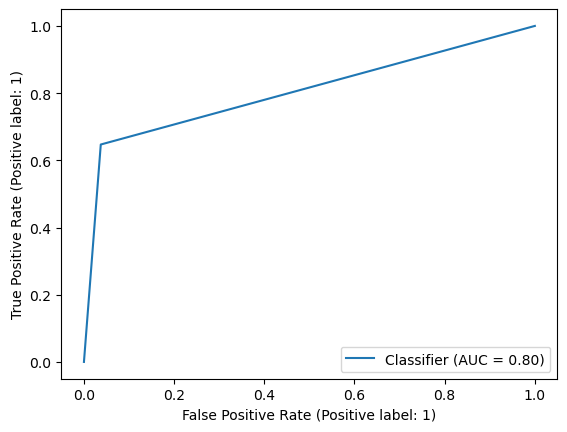

In [235]:
xgb_best = XGBClassifier(**search4.best_params_, random_state=42,n_jobs=-1)
xgb_best.fit(X_train, y_train)
y_hat = xgb_best.predict(X_test)

save_output(y_test,y_hat,'XGB')
reports(y_test, y_hat)

### CB Classifier

In [236]:
%%time 
par = {
    'depth': np.arange(5, 11, 1),
    'scale_pos_weight': np.arange(10, 110, 20),
    'penalties_coefficient': [0.001, 0.01, 0.03, 0.1, 0.3],
    'l2_leaf_reg': np.linspace(1, 6, 11),
    'random_strength': np.arange(0, 110, 20),
    'rsm': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'posterior_sampling': [False, True],
    'min_data_in_leaf': np.arange(3, 10, 1),
    'loss_function': ['Logloss'],
    'score_function': ['Cosine', 'L2'],
    'leaf_estimation_iterations': np.arange(5, 30, 5),
    'n_estimators': np.arange(100, 600, 100),
    'sampling_frequency': ['PerTreeLevel', 'PerTree'],
    'grow_policy': ['Symmetric', 'Depthwise']
}

cb = CatBoostClassifier(random_state=42,verbose=False)
search5 = RandomizedSearchCV(cb, par, n_jobs=-1, scoring='f1_macro',random_state=42)
search5.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search5.best_score_)
print(search5.best_params_)

Best parameter (CV score=0.701):
{'subsample': 0.9, 'score_function': 'L2', 'scale_pos_weight': 90, 'sampling_frequency': 'PerTreeLevel', 'rsm': 0.9, 'random_strength': 60, 'posterior_sampling': True, 'penalties_coefficient': 0.3, 'n_estimators': 500, 'min_data_in_leaf': 9, 'loss_function': 'Logloss', 'leaf_estimation_iterations': 20, 'l2_leaf_reg': 6.0, 'grow_policy': 'Depthwise', 'depth': 10}
CPU times: total: 2min 15s
Wall time: 2min 54s



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1313
           1       0.39      0.63      0.48        51

    accuracy                           0.95      1364
   macro avg       0.69      0.79      0.73      1364
weighted avg       0.96      0.95      0.95      1364



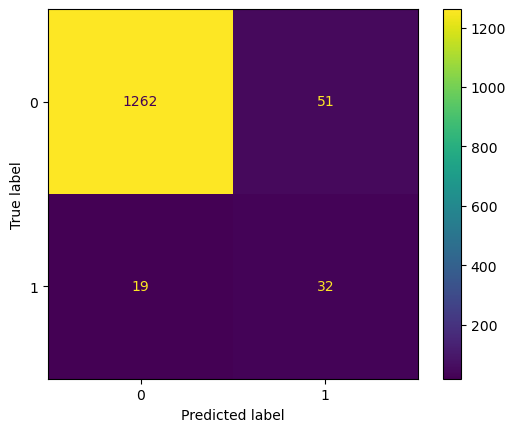

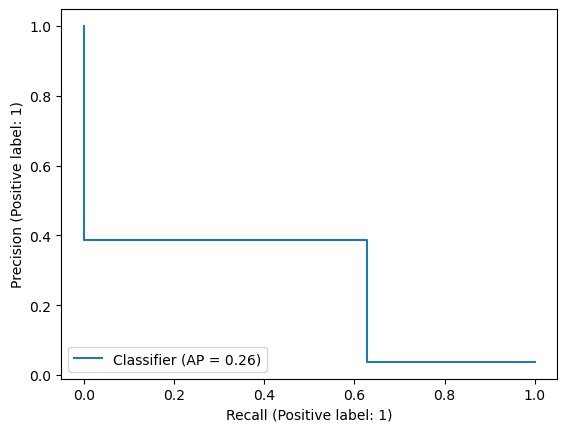

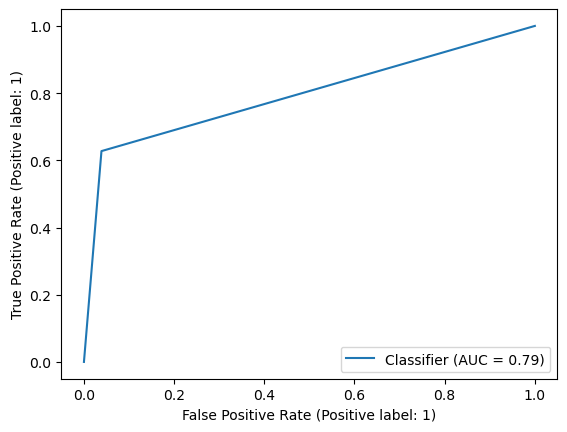

In [237]:
cb_best = CatBoostClassifier(**search5.best_params_, random_state=42,verbose=False)
cb_best.fit(X_train, y_train)
y_hat = cb_best.predict(X_test)

save_output(y_test,y_hat,'CB')
reports(y_test, y_hat)

### Support Vector Machine

In [238]:
%%time 
par = {
    'C':[0,.1,.5,1,1.5,1.6,1.7,1.8,1.9,2,2.25,3,5,10],
    'kernel':['poly','rbf','sigmoid'],
    'degree':[1,2,3,4,5,6],
    'gamma':['scale','auto'],
    'coef0':[1,1.2,1.3,1.4,1.5,1.75,2,2.1,2.2,3,4,5,6,7,8],
    'class_weight':[{0:1,1:1},{0:1,1:3},{0:1,1:5},{0:1,1:7},{0:1,1:10},{0:1,1:20},{0:1,1:30},{0:1,1:50},{0:1,1:75},'balanced']                    
}

svm = SVC(random_state=42)
search6 = RandomizedSearchCV(svm, par, n_jobs=-1, scoring='f1_macro',random_state=42)
search6.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search6.best_score_)
print(search6.best_params_)

Best parameter (CV score=0.652):
{'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'coef0': 2.1, 'class_weight': {0: 1, 1: 10}, 'C': 5}
CPU times: total: 766 ms
Wall time: 5.89 s



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1313
           1       0.33      0.75      0.46        51

    accuracy                           0.93      1364
   macro avg       0.66      0.84      0.71      1364
weighted avg       0.96      0.93      0.95      1364



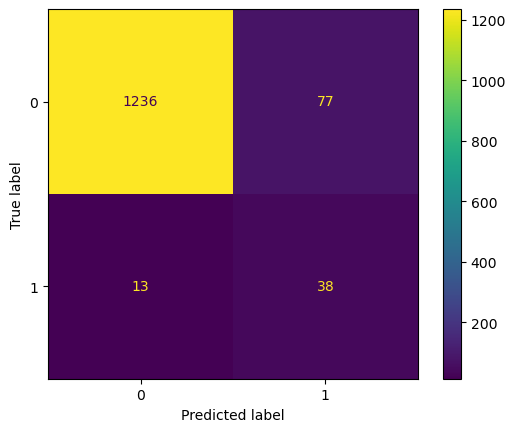

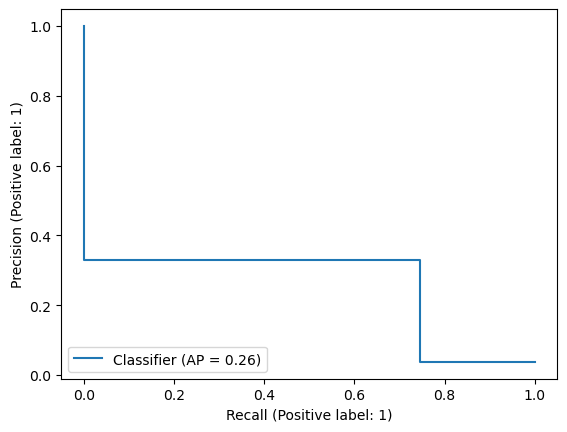

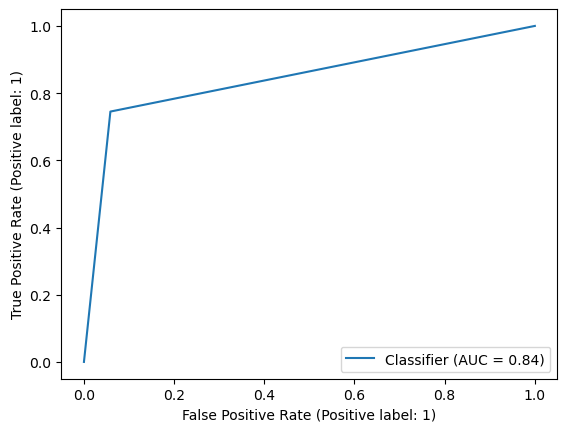

In [239]:
svm_best = SVC(**search6.best_params_, random_state=42,probability=True)
svm_best.fit(X_train, y_train)
y_hat = svm_best.predict(X_test)

save_output(y_test,y_hat,'SVM')
reports(y_test, y_hat)

### Ensembles

In [240]:
models_final = [logistic_best,rf_best,cb_best,xgb_best,svm_best]

for i in range(2, len(models_final) + 1):
    models_combinations = list(combinations(models_final, i))

    for combination in models_combinations:
        unique_combination = {str(model) for model in combination}
        if len(set(unique_combination)) == len(combination):
            ensemble_models = [(f'Model{j+1}', model) for j, model in enumerate(combination)]
            ensemble = VotingClassifier(estimators=ensemble_models, voting='hard',n_jobs=-1)
            ensemble.fit(X_train, y_train)
            y_hat = ensemble.predict(X_test)
            save_output(y_test,y_hat,f'{[model.__class__.__name__ for _, model in ensemble_models]}')

### Final results

In [244]:
models_sum = pd.DataFrame({'Model':models,
                          'F1_macro':f1_scores,
                          'ROC_AUC':roc_auc_scores,
                          'precision_macro':precision_scores,
                          'recall_macro':recall_scores})
models_sum.sort_values(by='F1_macro',ascending=False,inplace=True)
models_sum.reset_index(drop=True,inplace=True)
models_sum

,Model,F1_macro,ROC_AUC,precision_macro,recall_macro
0,"['XGBClassifier', 'SVC']",0.770,0.811,0.739,0.811
1,"['CatBoostClassifier', 'SVC']",0.754,0.799,0.721,0.799
2,"['RandomForestClassifier', 'SVC']",0.744,0.798,0.709,0.798
3,"['LogisticRegression', 'CatBoostClassifier', 'XGBClassifier', 'SVC']",0.744,0.798,0.709,0.798
4,"['RandomForestClassifier', 'CatBoostClassifier', 'XGBClassifier', 'SVC']",0.742,0.806,0.702,0.806
5,"['RandomForestClassifier', 'XGBClassifier']",0.740,0.788,0.708,0.788
6,"['CatBoostClassifier', 'XGBClassifier']",0.738,0.788,0.705,0.788
7,"['CatBoostClassifier', 'XGBClassifier', 'SVC']",0.735,0.814,0.691,0.814
8,XGB,0.735,0.805,0.694,0.805
9,"['RandomForestClassifier', 'CatBoostClassifier', 'XGBClassifier']",0.733,0.804,0.692,0.804



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1313
           1       0.49      0.65      0.56        51

    accuracy                           0.96      1364
   macro avg       0.74      0.81      0.77      1364
weighted avg       0.97      0.96      0.96      1364



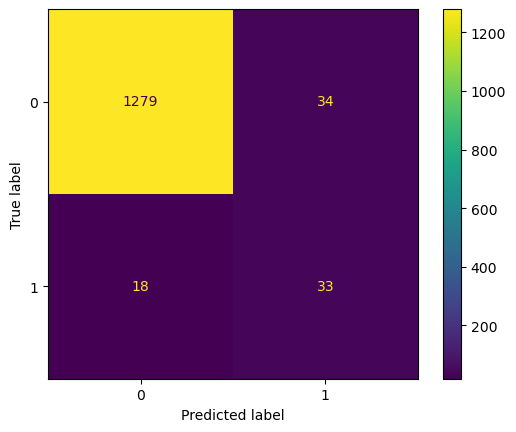

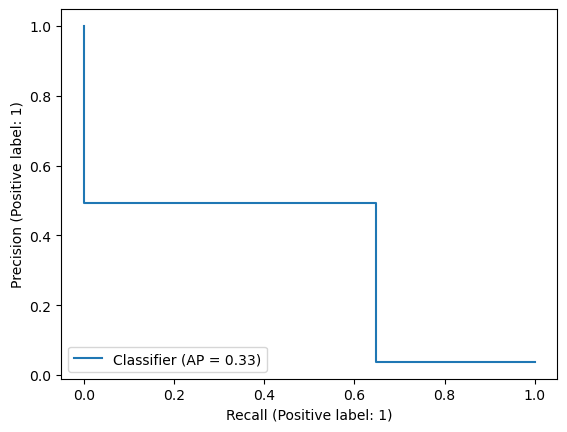

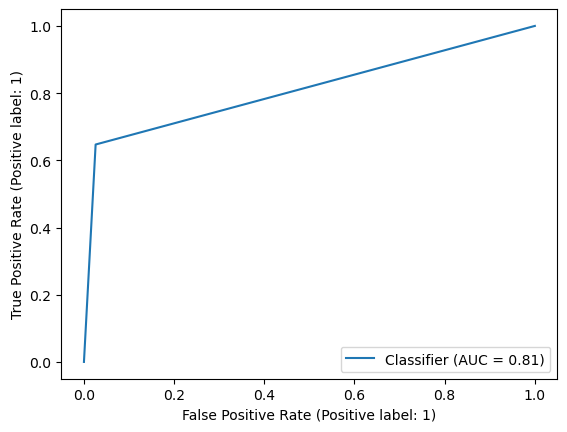

In [256]:
classifiers = [('xgb',xgb_best), ('svm',svm_best)]
ensemble = VotingClassifier(estimators=classifiers, voting='hard', n_jobs=-1)
ensemble.fit(X_train, y_train)
y_hat = ensemble.predict(X_test)
reports(y_test, y_hat)